# Disaster Tweets

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). This project aims to detect disaster tweets using a LSTM model.

### Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import string
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)
sns.set_style('whitegrid')

%matplotlib inline

In [3]:
train_tweets = pd.read_csv("../input/nlp-getting-started/train.csv")
test_tweets = pd.read_csv("../input/nlp-getting-started/test.csv")

In [4]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis

Text(0.5, 1.0, 'Disaster Tweets')

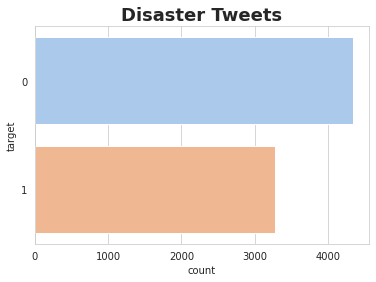

In [18]:
ax = sns.countplot(y=train_tweets['target'], palette='pastel', dodge=False)
ax.set_title('Disaster Tweets',fontsize = 18, fontweight='bold')

In [20]:
train_tweets['location'].value_counts().head(n=20)

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: location, dtype: int64

## Text Cleaning

- spelling correction
- removing punctuations
- removing html tags
- removing emojis

In [25]:
# Basic helper functions to clean text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
    
# Applying helper functions 
train_tweets['text_clean'] = train_tweets['text'].apply(
    lambda x: remove_URL(x)).apply(
    lambda x: remove_emoji(x)).apply(
    lambda x: remove_html(x)).apply(
    lambda x: remove_punct(x)
)

test_tweets['text_clean'] = test_tweets['text'].apply(
    lambda x: remove_URL(x)).apply(
    lambda x: remove_emoji(x)).apply(
    lambda x: remove_html(x)).apply(
    lambda x: remove_punct(x)
)

## Further Data Preprocessing

In [26]:
train_tweets.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...


In [27]:
test_tweets.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan


#### Convert dataframe columns to lists

In [30]:
training_message = list(train_tweets.text_clean.values)
training_labels = list(train_tweets.target.values)
testing_message = list(test_tweets.text_clean)

#### Tokenization

In [47]:
# parameters
vocab_size = 23000
embedding_dim = 32
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [33]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_message)
word_index = tokenizer.word_index

#### Text to Sequence

In [34]:
training_message = tokenizer.texts_to_sequences(training_message)
testing_message = tokenizer.texts_to_sequences(testing_message)

In [42]:
training_message[:2]

[[110, 4492, 21, 2, 825, 6, 19, 241, 123, 1567, 4493, 69, 38],
 [179, 41, 218, 680, 6740, 6741, 1348]]

#### Pad Sequences

In [43]:
training_padded = pad_sequences(
    training_message,
    maxlen=max_length, 
    truncating=trunc_type, 
    padding=padding_type)

testing_padded = pad_sequences(
    testing_message,
    maxlen=max_length, 
    truncating=trunc_type, 
    padding=padding_type)

In [44]:
training_padded = np.array(training_padded)
testing_padded = np.array(testing_padded)
training_labels = np.array(training_labels)

print(training_padded[0])
print(testing_padded[0])
print(training_labels[0])

[[ 110 4492   21    2  825    6   19  241  123 1567 4493   69   38    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
[[  29  874    3 1893  121   83    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    

## Creating LSTM Model using Keras

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=[
        'accuracy', 
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

# summary of model architecture
model.summary()

2022-07-14 12:10:09.648718: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           736000    
_________________________________________________________________
bidirectional (Bidirectional (None, 24)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 740,345
Trainable params: 740,345
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(
    training_padded, 
    training_labels, 
    epochs = 50,
    batch_size = 64,  
    validation_split=0.2
)

Epoch 1/50
96/96 [==============================] - 8s 80ms/step - loss: 0.3380 - accuracy: 0.8718 - precision: 0.8867 - recall: 0.7970 - val_loss: 0.4812 - val_accuracy: 0.7807 - val_precision: 0.7737 - val_recall: 0.7475
Epoch 2/50
96/96 [==============================] - 7s 77ms/step - loss: 0.3197 - accuracy: 0.8834 - precision: 0.8978 - recall: 0.8158 - val_loss: 0.4778 - val_accuracy: 0.7781 - val_precision: 0.8193 - val_recall: 0.6714
Epoch 3/50
96/96 [==============================] - 8s 86ms/step - loss: 0.3016 - accuracy: 0.8916 - precision: 0.8989 - recall: 0.8365 - val_loss: 0.4837 - val_accuracy: 0.7741 - val_precision: 0.8288 - val_recall: 0.6488
Epoch 4/50
96/96 [==============================] - 7s 77ms/step - loss: 0.2842 - accuracy: 0.8990 - precision: 0.9155 - recall: 0.8372 - val_loss: 0.4835 - val_accuracy: 0.7722 - val_precision: 0.7528 - val_recall: 0.7602
Epoch 5/50
96/96 [==============================] - 7s 76ms/step - loss: 0.2695 - accuracy: 0.9062 - precisi

## Plotting Performance

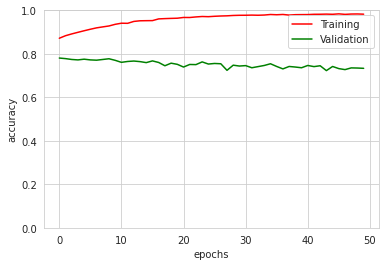

In [50]:
plt.plot(history.history["accuracy"], color="r")
plt.plot(history.history["val_accuracy"], color="g")
plt.ylim([0,1])

plt.legend(["Training", "Validation"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [51]:
test_predict = model.predict(testing_padded).round().astype(int)

In [53]:
test_predict.shape

(3263, 1)

In [77]:
pred_1 = np.where(test_predict.flatten() == 1)[0]
msg = list(test_tweets.text_clean)

printed = 0
for pred in pred_1[:10]:
    print(msg[pred])
    print()

Just happened a terrible car crash

there is a forest fire at spot pond geese are fleeing across the street I cannot save them all

Apocalypse lighting Spokane wildfires

Typhoon Soudelor kills 28 in China and Taiwan

Were shakingIts an earthquake

PreviouslyOnDoyinTv Toke MakinwaÛªs marriage crisis sets Nigerian Twitter ablaze 

Burning Man Ablaze by Turban Diva  via Etsy

Rape victim dies as she sets herself ablaze A 16yearold girl died of burn injuries as she set herself ablazeÛ 

CTVToronto the bins in front of the field by my house wer set ablaze the other day flames went rite up the hydro pole wonder if it was him

Burning Rahm Lets hope City Hall builds a giant wooden mayoral effigy 100 feet tall  sets it ablaze  JohnKass



In [ ]:
submission = pd.DataFrame({
    'id':df_test['id'],
    'target':test_predict.ravel()
})

submission.to_csv('submission.csv',index=False)